Like every project,let's look into some images and their keypoints.

**Load and visualize trhe data**

In [ ]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

In [ ]:
train_df = pd.read_csv('data/training_frames_keypoints.csv')
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [ ]:
test_df=pd.read_csv("data/test_frames_keypoints.csv")

In [ ]:
test_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,64.0,27.0,67.0,30.0,71.0,33.0,75.0,39.0,76.0,46.0,76.0,52.0,74.0,56.0,72.0,59.0,67.0,62.0,62.0,63.0,57.0,64.0,52.0,65.0,47.0,27.0,40.0,30.0,39.0,32.0,...,33.0,65.0,36.0,64.0,38.0,64.0,39.0,65.0,41.0,64.0,44.0,65.0,47.0,65.0,44.0,66.0,42.0,68.0,39.0,68.0,37.0,68.0,36.0,66.0,33.0,65.0,38.0,65.0,39.0,65.0,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,101.0,57.0,108.0,60.0,114.0,65.0,121.0,75.0,127.0,88.0,124.0,98.0,122.0,106.0,117.0,114.0,112.0,122.0,102.0,124.0,94.0,129.0,87.0,129.0,76.0,57.0,52.0,60.0,50.0,65.0,...,65.0,101.0,68.0,101.0,70.0,98.0,75.0,101.0,78.0,101.0,83.0,104.0,88.0,106.0,83.0,109.0,78.0,109.0,73.0,109.0,70.0,109.0,68.0,106.0,65.0,101.0,70.0,104.0,75.0,104.0,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,127.0,73.0,135.0,78.0,137.0,83.0,140.0,96.0,143.0,109.0,138.0,119.0,135.0,127.0,130.0,132.0,125.0,135.0,115.0,135.0,105.0,137.0,95.0,137.0,84.0,63.0,75.0,65.0,70.0,71.0,...,78.0,119.0,83.0,114.0,89.0,112.0,91.0,112.0,94.0,112.0,101.0,112.0,109.0,117.0,101.0,120.0,96.0,122.0,94.0,122.0,89.0,122.0,83.0,122.0,81.0,119.0,89.0,117.0,91.0,114.0,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,128.0,64.0,135.0,73.0,139.0,83.0,144.0,96.0,144.0,105.0,137.0,107.0,133.0,107.0,127.0,109.0,120.0,109.0,112.0,109.0,103.0,109.0,95.0,107.0,86.0,60.0,83.0,66.0,79.0,73.0,...,83.0,122.0,90.0,120.0,94.0,116.0,98.0,116.0,100.0,116.0,103.0,116.0,103.0,118.0,103.0,122.0,100.0,125.0,98.0,127.0,94.0,127.0,90.0,124.0,83.0,122.0,94.0,120.0,96.0,118.0,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,96.0,51.0,103.0,58.0,108.0,66.0,112.0,76.0,112.0,85.0,107.0,91.0,100.0,94.0,93.0,96.0,84.0,96.0,77.0,96.0,70.0,96.0,64.0,94.0,55.0,42.0,67.0,48.0,65.0,51.0,...,60.0,94.0,64.0,96.0,69.0,94.0,73.0,94.0,74.0,94.0,80.0,94.0,83.0,93.0,80.0,98.0,78.0,101.0,73.0,101.0,69.0,101.0,66.0,99.0,60.0,94.0,69.0,96.0,73.0,96.0,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


In [ ]:
train_df.shape,test_df.shape

((3462, 137), (770, 137))

In the training set,there are 3462 images.  And there 136 columns for annotations means there are 68 keypoints and correspond to each keypoint we have 2(x,y) coordinates

So we have to make those data into shape of (68,2) matrix.

Let's Visualize.

In [ ]:
def show_keypoints(image, key_pts):
  '''
    Showing image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
  '''  
  
  plt.imshow(image)
  plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

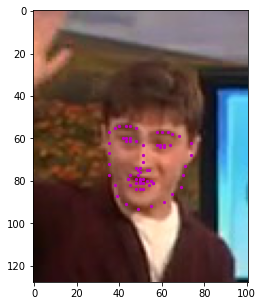

In [ ]:
# Display a few different types of images by changing the index n
# select an image by index in our data frame
n = 6
image_name =train_df.iloc[n, 0]
key_pts = train_df.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

Here we go. This is what keypoints look like. Our task is to predict those points given a simple image.

**Preparaing the Data using Dataset Class and transformations class of Pytorch**

This dataset class is inspired from this [tutorial from pytorch website](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)




In [ ]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face keypoints dataset."""

    def __init__(self, csv_file, root_dir,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.df.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Now that we've defined this class, let's instantiate the dataset and display some images.

In [ ]:
# Constructing the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


In [ ]:
#let's explore size of some iamegs
for i in range(5):
  print(face_dataset[i]["image"].shape)

(192, 176, 3)
(196, 157, 3)
(190, 170, 3)
(240, 213, 3)
(191, 184, 3)


observe each one is of different size. So we will need to resize that in Transfrom class.

Let's Display a few of the images from the dataset 

0 (360, 429, 3) (68, 2)
1 (275, 254, 3) (68, 2)
2 (127, 142, 3) (68, 2)


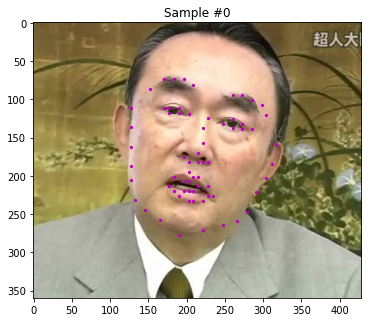

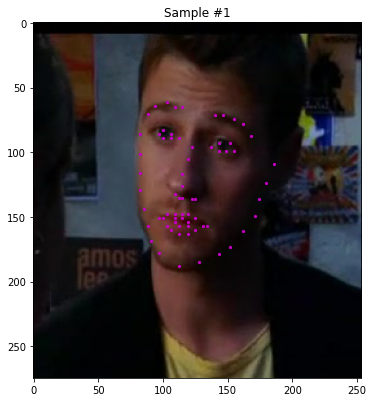

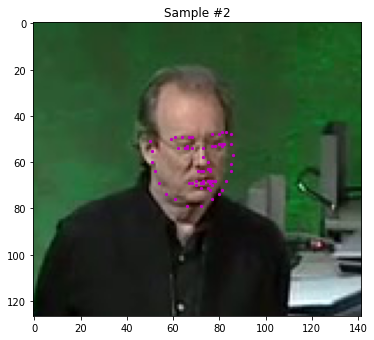

In [ ]:
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

Notice the shapes of Images. They are not of same shape.
Neural networks  expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code. Let's create four transforms:

Normalize: to convert a color image to grayscale values with a range of [0,1] by dividing eith 255

Rescale: to rescale an image to a desired size.

RandomCrop: to crop an image randomly.

ToTensor: to convert numpy images to torch images.

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it's called. For this, we just need to implement __call__ method and (if we require parameters to be passed in), the __init__ method. We can then use a transform like this:

tx = Transform(params)

transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.

**Transforms**

In [ ]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Normalize the color range to [0,1] and convert a color image to grayscale if needed"""        
    def __init__(self, color = False):
        self.color = color
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        if not self.color:
            image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        key_pts_copy = (key_pts_copy - image.shape[0])/(image.shape[0])


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. 
             If tuple, output is matched to output_size.(mostly we will use this) 
             If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
            
        img = cv2.resize(image, (new_w, new_h))
                 
        # scaling the pts-
        key_pts = key_pts * [new_w / w, new_h / h]
        
        return {'image': img, 'keypoints': key_pts}
      
class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

Let's check out the transformation

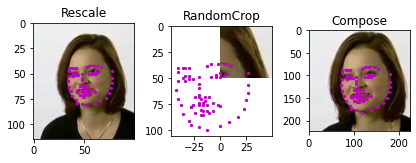

In [ ]:

# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num =207
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

Apart from above transformation,we can put more transformatiomns like random flip,horizontal flip,random rotatate etc.

I have to put created  classes of FacialKeypointsDataset and transforms to "load_data.py" .such that we can use them in further notebooks for modellling.